I have tried 3 models for ChEMBL286 dataset[1,2] (renin enzyme[3]).
Firstly, I used a basic CNN model, then I used a CNN model for feature extraction and a CatBoost model for classification. Lastly, I combined two models. 

I have used the following methods.

* A basic CNN model (Model 1)
* A CNN model with elu activation function for the feature extraction, and CatBoostClassifier for the classification stage (Model 2)
* Custom convolution block
* Custom callback class  that used predicting a sample from the validation in dataset during training
* Weighted ensemble method for the last prediction (Model 3)

## References
1. https://github.com/cansyl/ DEEPscreen
2. https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL286/
3. https://my.clevelandclinic.org/health/body/22506-renin#:~:text=Renin%20is%20an%20enzyme%20that,blood%20pressure%20drops%20too%20low.

In [194]:
from IPython.display import clear_output
!pip install catboost
!pip install visualkeras
clear_output()

In [196]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import cv2
import visualkeras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Dense, Input, BatchNormalization
from tensorflow.keras.layers import Layer, Activation, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

BATCH_SIZE = 8

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/CHEMBL286/train_val_test_dict.json', 'r') as f:
  data = json.load(f)

In [4]:
# Creating a function that used converting json to dataframe

def create_df(json_data, main_path, set_name = 'training'):
  images = []
  labels = []

  for i in range(len(json_data[set_name])):
    img_link = main_path + data[set_name][i][0] + '.png'
    img_label = data[set_name][i][1]

    images.append(img_link)
    labels.append(img_label)

  df = pd.DataFrame({'images': images, 'labels' : labels })

  return df




In [5]:
train_data = create_df(data,'/content/drive/MyDrive/Colab Notebooks/CHEMBL286/imgs/', 'training' )
validation_data = create_df(data,'/content/drive/MyDrive/Colab Notebooks/CHEMBL286/imgs/', 'validation' )
test_data = create_df(data,'/content/drive/MyDrive/Colab Notebooks/CHEMBL286/imgs/', 'test' )

In [6]:
print("train images: ", train_data.shape[0])
print("val images: ", validation_data.shape[0])
print("test images: ", test_data.shape[0])

train images:  1183
val images:  297
test images:  372


#Creating Datasets

In [7]:
def img_preprocessing(image, label):
  img = tf.io.read_file(image)
  img = tf.io.decode_png(img, channels = 3)
  img = tf.image.resize(img, size = (150, 150))
  img = tf.cast(img, tf.float32) / 255.0

  return img, label

In [8]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices(( train_data['images'], train_data['labels'] ))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .shuffle(train_data['images'].shape[0])
                 .prefetch(BATCH_SIZE))

# train dataset for the second model without shuffle
train_dataset_without_shuffle = (train_loader
                                 .map(img_preprocessing)
                                 .batch(BATCH_SIZE)
                                 .prefetch(BATCH_SIZE))



validation_loader = tf.data.Dataset.from_tensor_slices(( validation_data['images'], validation_data['labels'] ))
validation_dataset = (validation_loader
                      .map(img_preprocessing)
                      .batch(BATCH_SIZE)
                      .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices(( test_data['images'], test_data['labels'] ))
test_dataset = (test_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))


In [9]:
# Convolution block class

class ConvBlock(Layer):

  def __init__(self, filters, kernel_size, activation = 'relu', batchnormalization = False, **kwargs):
    super(ConvBlock, self).__init__(**kwargs)

    self.filters = filters
    self.kernel_size = kernel_size
    self.activation = activation
    self.batchnormalization = batchnormalization

    self.conv = Conv2D(filters, kernel_size, padding = 'same')
    self.batch = BatchNormalization()
    self.act = Activation(activation)
    self.pool = MaxPooling2D()


  def call(self, inputs):

    X = self.conv(inputs)
    if self.batchnormalization:
      X = self.batch(X)
      X = self.act(X)
      X = self.pool(X)
      return X
    else:
      X = self.act(X)
      X = self.pool(X)
      return X


  def get_config():
    base_config = super().get_config()

    return {
        **base_config,
        "filters" : self.filters,
        "kernel_size": self.kernel_size,
        "activation" : self.act
    }


In [10]:
# Custom callback for predicting 5 samples from validation dataset during training

# Red color title for a false prediction
# Green color title for a true prediction

class PredictDuringTraining(Callback):
  def on_epoch_end(self, epochs, logs = None):
    samples = list(validation_dataset.take(-1))

    idxs = np.random.permutation(validation_data.shape[0])[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs


    p1 = samples[batch_idx[0]][0][image_idx[0]][np.newaxis,...]
    p2 = samples[batch_idx[1]][0][image_idx[1]][np.newaxis,...]
    p3 = samples[batch_idx[2]][0][image_idx[2]][np.newaxis,...]
    p4 = samples[batch_idx[3]][0][image_idx[3]][np.newaxis,...]
    p5 = samples[batch_idx[4]][0][image_idx[4]][np.newaxis,...]


    images = tf.concat([ p1, p2, p3, p4, p5 ], axis = 0 )


    pred = self.model.predict(images, verbose = 0)
    pred = np.squeeze(pred)
    pred = np.round(pred)


    fig, axs = plt.subplots(1,5, figsize = (6,2), dpi = 150)

    #fig.suptitle('Epoch no: ' + str(epochs + 1) + ' ,(github.com/john-fante)', fontsize= 7 )


    for i in range(5):
      axs[i].imshow(samples[batch_idx[i]][0][image_idx[i]])
      axs[i].axis('off')

      if (samples[batch_idx[i]][1][image_idx[i]].numpy() == pred[i]):
        if (pred[i] == 0):
          axs[i].set_title('Non active', fontsize = 8, color = 'green' )
        elif (pred[i] == 1):
          axs[i].set_title('Active', fontsize = 8, color = 'green' )


      elif (samples[batch_idx[i]][1][image_idx[i]].numpy() != pred[i]):
          if (samples[batch_idx[i]][1][image_idx[i]].numpy() == 0):
            axs[i].set_title('Non active', fontsize = 8, color = 'red' )
          elif (samples[batch_idx[i]][1][image_idx[i]].numpy() == 1):
            axs[i].set_title('Active', fontsize = 8, color = 'red' )



    plt.tight_layout()
    plt.show()


#Model 1: CNN Model

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (ConvBlock)           (None, 75, 75, 32)        416       
                                                                 
 conv2 (ConvBlock)           (None, 37, 37, 64)        8256      
                                                                 
 conv3 (ConvBlock)           (None, 18, 18, 128)       32896     
                                                                 
 global_average_pooling2d_6  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                           

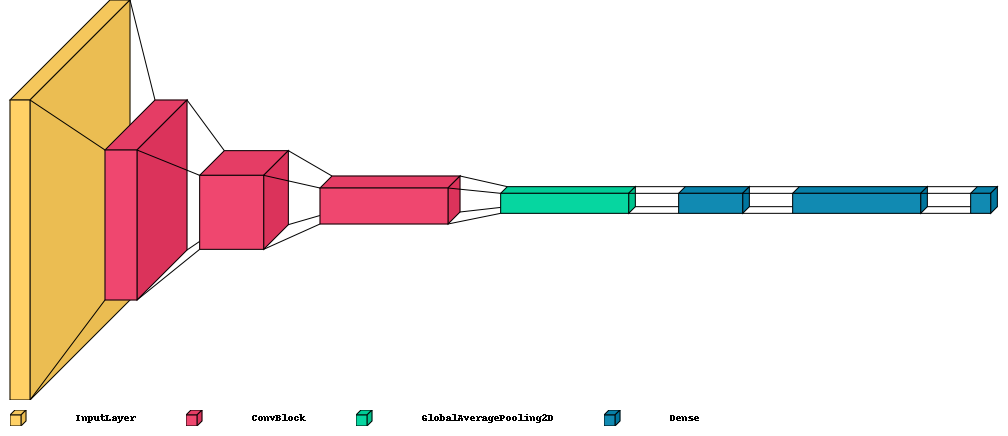

<Figure size 640x480 with 0 Axes>

In [197]:
inp = Input(shape = (150, 150, 3))
c = ConvBlock(32, 2, activation = 'relu', batchnormalization = False, name = 'conv1')(inp)
c = ConvBlock(64, 2, activation = 'relu', batchnormalization = False , name = 'conv2')(c)
c = ConvBlock(128, 2, activation = 'relu', batchnormalization = False, name = 'conv3' )(c)

c = GlobalAveragePooling2D()(c)
c = Dense(64, activation = 'relu')(c)
c = Dense(128, activation = 'relu')(c)
out = Dense(1, activation = 'sigmoid')(c)

model = Model(inputs = inp, outputs = out)
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss ='binary_crossentropy', metrics = [ 'AUC', 'Precision', 'Recall' , 'mae', 'mse'] )
my_callbacks = [PredictDuringTraining()]

#Plotting the model

plt.figure(dpi = 100)
visualkeras.layered_view(model, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True)


Epoch 1/50
148/148 [==============================] - ETA: 0s - loss: 0.6847 - auc: 0.4764 - precision: 0.6002 - recall: 1.0000 - mae: 0.4862 - mse: 0.2454

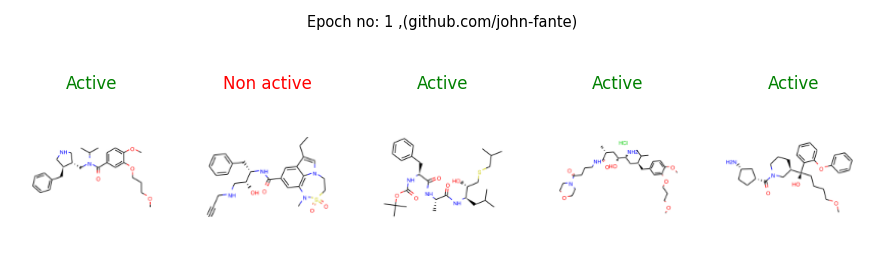

148/148 [==============================] - 26s 152ms/step - loss: 0.6847 - auc: 0.4764 - precision: 0.6002 - recall: 1.0000 - mae: 0.4862 - mse: 0.2454 - val_loss: 0.6750 - val_auc: 0.5000 - val_precision: 0.5993 - val_recall: 1.0000 - val_mae: 0.4861 - val_mse: 0.2410
Epoch 2/50
148/148 [==============================] - ETA: 0s - loss: 0.6769 - auc: 0.4762 - precision: 0.6002 - recall: 1.0000 - mae: 0.4841 - mse: 0.2419

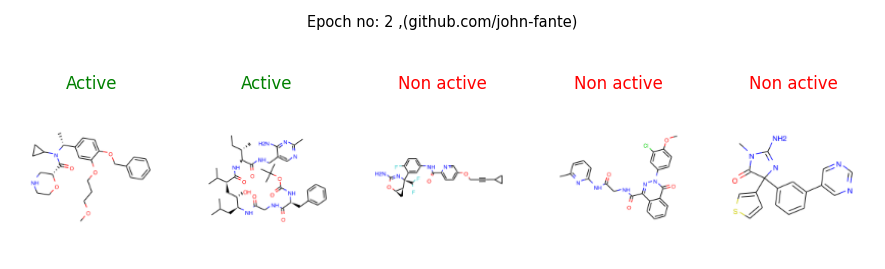

148/148 [==============================] - 24s 151ms/step - loss: 0.6769 - auc: 0.4762 - precision: 0.6002 - recall: 1.0000 - mae: 0.4841 - mse: 0.2419 - val_loss: 0.6733 - val_auc: 0.5000 - val_precision: 0.5993 - val_recall: 1.0000 - val_mae: 0.4781 - val_mse: 0.2401
Epoch 3/50
148/148 [==============================] - ETA: 0s - loss: 0.6744 - auc: 0.5219 - precision: 0.6002 - recall: 1.0000 - mae: 0.4786 - mse: 0.2405

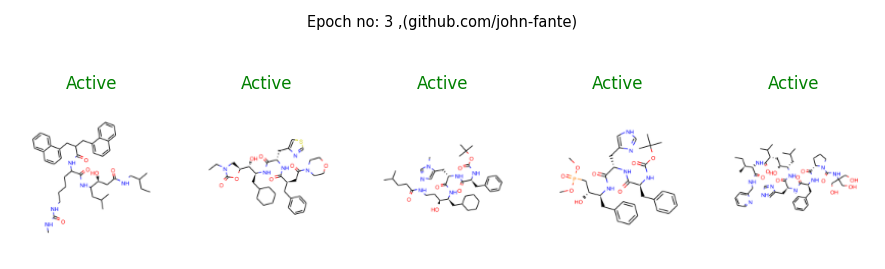

148/148 [==============================] - 22s 144ms/step - loss: 0.6744 - auc: 0.5219 - precision: 0.6002 - recall: 1.0000 - mae: 0.4786 - mse: 0.2405 - val_loss: 0.6736 - val_auc: 0.5000 - val_precision: 0.5993 - val_recall: 1.0000 - val_mae: 0.4831 - val_mse: 0.2403
Epoch 4/50
148/148 [==============================] - ETA: 0s - loss: 0.6747 - auc: 0.4766 - precision: 0.6002 - recall: 1.0000 - mae: 0.4819 - mse: 0.2408

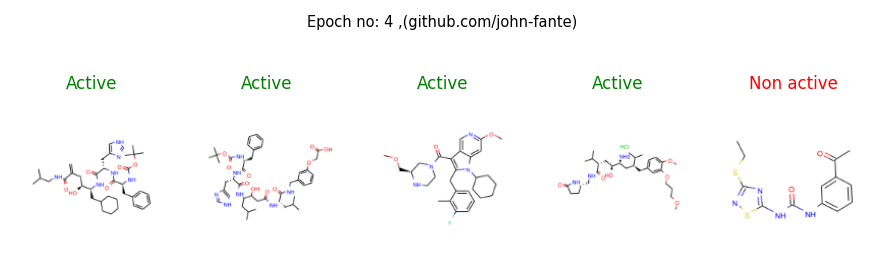

148/148 [==============================] - 22s 144ms/step - loss: 0.6747 - auc: 0.4766 - precision: 0.6002 - recall: 1.0000 - mae: 0.4819 - mse: 0.2408 - val_loss: 0.6734 - val_auc: 0.5084 - val_precision: 0.5993 - val_recall: 1.0000 - val_mae: 0.4823 - val_mse: 0.2402
Epoch 5/50
148/148 [==============================] - ETA: 0s - loss: 0.6753 - auc: 0.4923 - precision: 0.6002 - recall: 1.0000 - mae: 0.4830 - mse: 0.2411

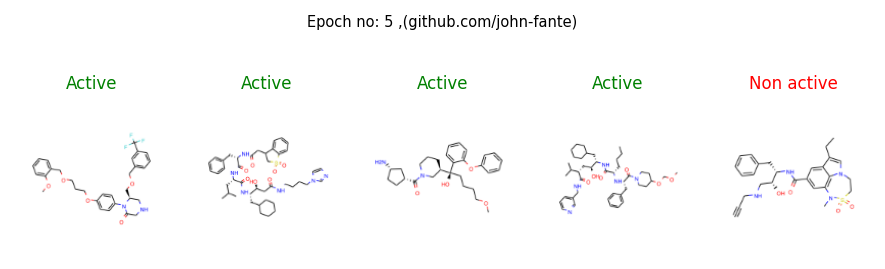

148/148 [==============================] - 23s 144ms/step - loss: 0.6753 - auc: 0.4923 - precision: 0.6002 - recall: 1.0000 - mae: 0.4830 - mse: 0.2411 - val_loss: 0.6729 - val_auc: 0.5436 - val_precision: 0.5993 - val_recall: 1.0000 - val_mae: 0.4802 - val_mse: 0.2400
Epoch 6/50
148/148 [==============================] - ETA: 0s - loss: 0.6738 - auc: 0.5028 - precision: 0.6002 - recall: 1.0000 - mae: 0.4799 - mse: 0.2404

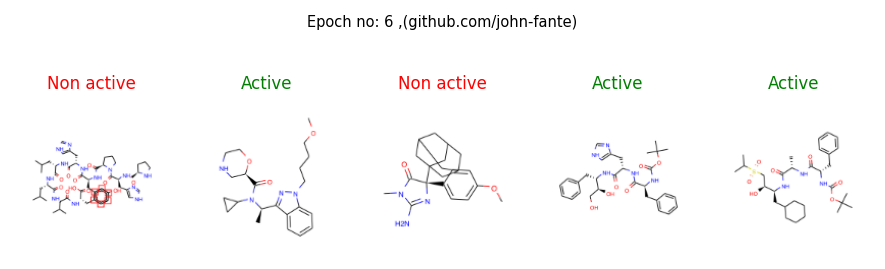

148/148 [==============================] - 22s 138ms/step - loss: 0.6738 - auc: 0.5028 - precision: 0.6002 - recall: 1.0000 - mae: 0.4799 - mse: 0.2404 - val_loss: 0.6711 - val_auc: 0.4903 - val_precision: 0.5993 - val_recall: 1.0000 - val_mae: 0.4794 - val_mse: 0.2391
Epoch 7/50
148/148 [==============================] - ETA: 0s - loss: 0.6681 - auc: 0.5580 - precision: 0.6043 - recall: 0.9789 - mae: 0.4761 - mse: 0.2375

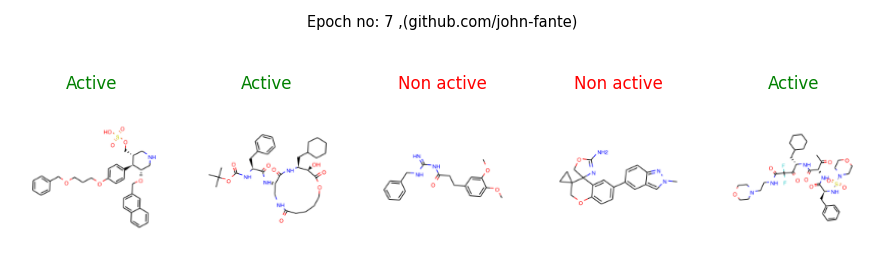

148/148 [==============================] - 23s 149ms/step - loss: 0.6681 - auc: 0.5580 - precision: 0.6043 - recall: 0.9789 - mae: 0.4761 - mse: 0.2375 - val_loss: 0.6717 - val_auc: 0.5151 - val_precision: 0.6000 - val_recall: 0.9944 - val_mae: 0.4741 - val_mse: 0.2394
Epoch 8/50
148/148 [==============================] - ETA: 0s - loss: 0.6611 - auc: 0.5383 - precision: 0.6241 - recall: 0.9493 - mae: 0.4674 - mse: 0.2340

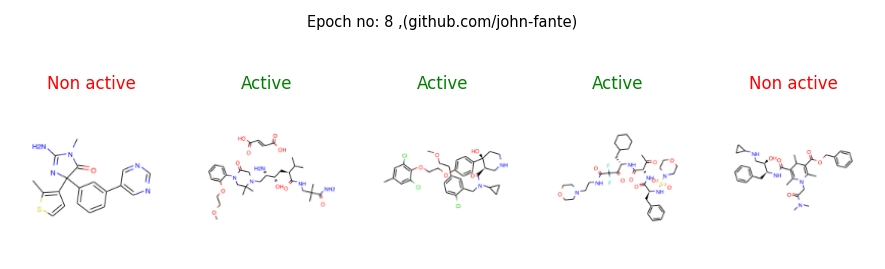

148/148 [==============================] - 25s 158ms/step - loss: 0.6611 - auc: 0.5383 - precision: 0.6241 - recall: 0.9493 - mae: 0.4674 - mse: 0.2340 - val_loss: 0.6663 - val_auc: 0.5837 - val_precision: 0.6055 - val_recall: 0.9831 - val_mae: 0.4752 - val_mse: 0.2369
Epoch 9/50
148/148 [==============================] - ETA: 0s - loss: 0.6556 - auc: 0.5676 - precision: 0.6242 - recall: 0.9521 - mae: 0.4631 - mse: 0.2316

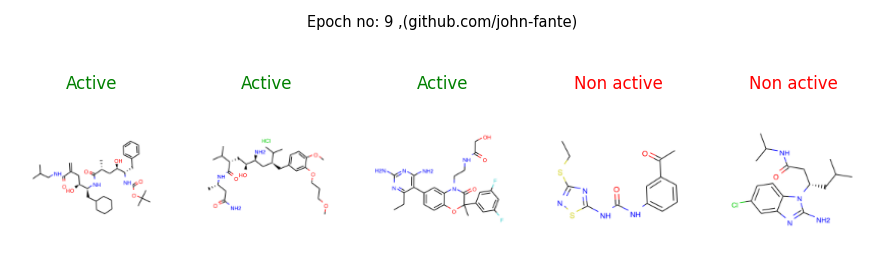

148/148 [==============================] - 23s 147ms/step - loss: 0.6556 - auc: 0.5676 - precision: 0.6242 - recall: 0.9521 - mae: 0.4631 - mse: 0.2316 - val_loss: 0.6685 - val_auc: 0.5312 - val_precision: 0.6028 - val_recall: 0.9719 - val_mae: 0.4784 - val_mse: 0.2380
Epoch 10/50
148/148 [==============================] - ETA: 0s - loss: 0.6526 - auc: 0.5401 - precision: 0.6317 - recall: 0.9592 - mae: 0.4633 - mse: 0.2303

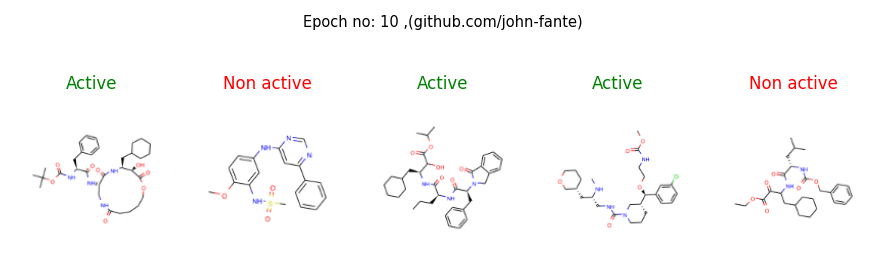

148/148 [==============================] - 23s 143ms/step - loss: 0.6526 - auc: 0.5401 - precision: 0.6317 - recall: 0.9592 - mae: 0.4633 - mse: 0.2303 - val_loss: 0.6577 - val_auc: 0.5450 - val_precision: 0.6232 - val_recall: 0.9663 - val_mae: 0.4667 - val_mse: 0.2329
Epoch 11/50
148/148 [==============================] - ETA: 0s - loss: 0.6518 - auc: 0.5448 - precision: 0.6306 - recall: 0.9592 - mae: 0.4597 - mse: 0.2296

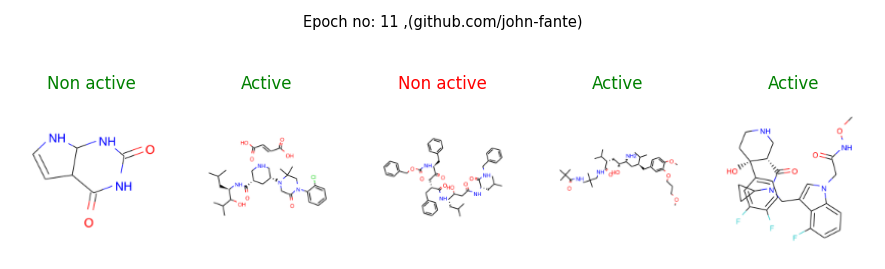

148/148 [==============================] - 23s 147ms/step - loss: 0.6518 - auc: 0.5448 - precision: 0.6306 - recall: 0.9592 - mae: 0.4597 - mse: 0.2296 - val_loss: 0.6572 - val_auc: 0.5464 - val_precision: 0.6232 - val_recall: 0.9663 - val_mae: 0.4655 - val_mse: 0.2327
Epoch 12/50
148/148 [==============================] - ETA: 0s - loss: 0.6491 - auc: 0.5751 - precision: 0.6329 - recall: 0.9592 - mae: 0.4566 - mse: 0.2283

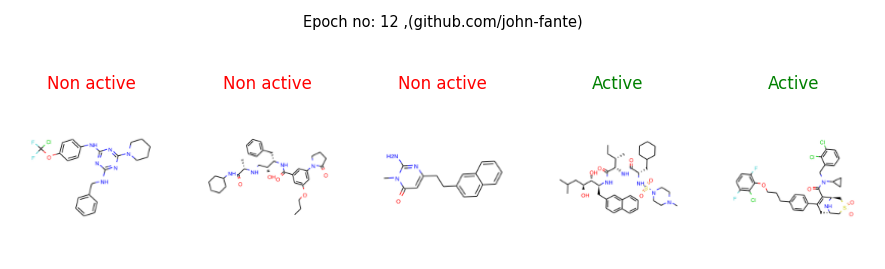

148/148 [==============================] - 24s 156ms/step - loss: 0.6491 - auc: 0.5751 - precision: 0.6329 - recall: 0.9592 - mae: 0.4566 - mse: 0.2283 - val_loss: 0.6531 - val_auc: 0.6617 - val_precision: 0.6218 - val_recall: 0.9607 - val_mae: 0.4578 - val_mse: 0.2311
Epoch 13/50
148/148 [==============================] - ETA: 0s - loss: 0.6432 - auc: 0.5900 - precision: 0.6402 - recall: 0.9423 - mae: 0.4481 - mse: 0.2260

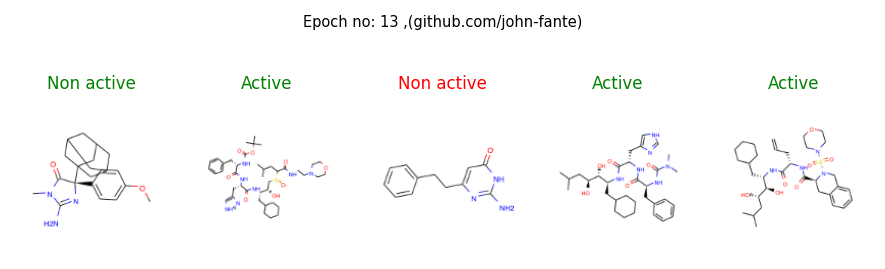

148/148 [==============================] - 24s 150ms/step - loss: 0.6432 - auc: 0.5900 - precision: 0.6402 - recall: 0.9423 - mae: 0.4481 - mse: 0.2260 - val_loss: 0.6527 - val_auc: 0.6932 - val_precision: 0.6201 - val_recall: 0.9719 - val_mae: 0.4592 - val_mse: 0.2307
Epoch 14/50
148/148 [==============================] - ETA: 0s - loss: 0.6445 - auc: 0.5830 - precision: 0.6343 - recall: 0.9577 - mae: 0.4575 - mse: 0.2268

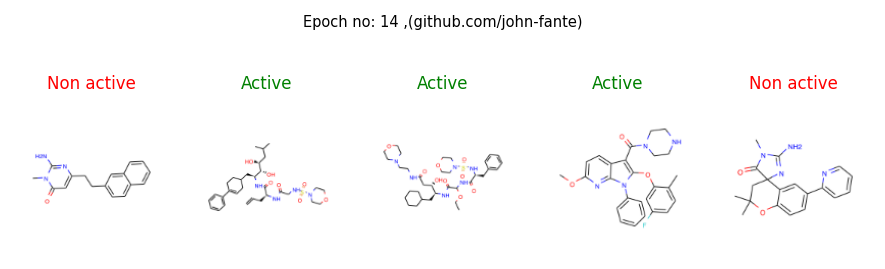

148/148 [==============================] - 22s 142ms/step - loss: 0.6445 - auc: 0.5830 - precision: 0.6343 - recall: 0.9577 - mae: 0.4575 - mse: 0.2268 - val_loss: 0.6611 - val_auc: 0.7065 - val_precision: 0.6154 - val_recall: 0.9888 - val_mae: 0.4551 - val_mse: 0.2345
Epoch 15/50
148/148 [==============================] - ETA: 0s - loss: 0.6415 - auc: 0.6025 - precision: 0.6333 - recall: 0.9704 - mae: 0.4480 - mse: 0.2254

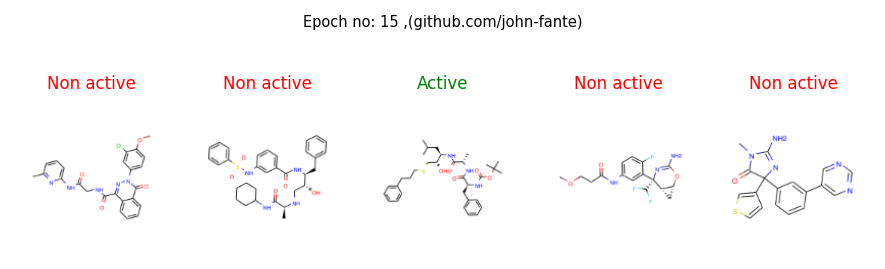

148/148 [==============================] - 24s 151ms/step - loss: 0.6415 - auc: 0.6025 - precision: 0.6333 - recall: 0.9704 - mae: 0.4480 - mse: 0.2254 - val_loss: 0.6440 - val_auc: 0.7243 - val_precision: 0.6184 - val_recall: 0.9831 - val_mae: 0.4496 - val_mse: 0.2272
Epoch 16/50
148/148 [==============================] - ETA: 0s - loss: 0.6325 - auc: 0.6371 - precision: 0.6366 - recall: 0.9648 - mae: 0.4424 - mse: 0.2219

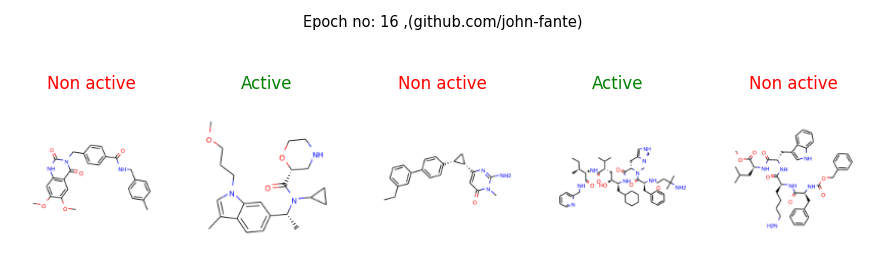

148/148 [==============================] - 24s 157ms/step - loss: 0.6325 - auc: 0.6371 - precision: 0.6366 - recall: 0.9648 - mae: 0.4424 - mse: 0.2219 - val_loss: 0.6423 - val_auc: 0.7382 - val_precision: 0.6175 - val_recall: 0.9888 - val_mae: 0.4543 - val_mse: 0.2259
Epoch 17/50
148/148 [==============================] - ETA: 0s - loss: 0.6263 - auc: 0.6998 - precision: 0.6342 - recall: 0.9718 - mae: 0.4375 - mse: 0.2183

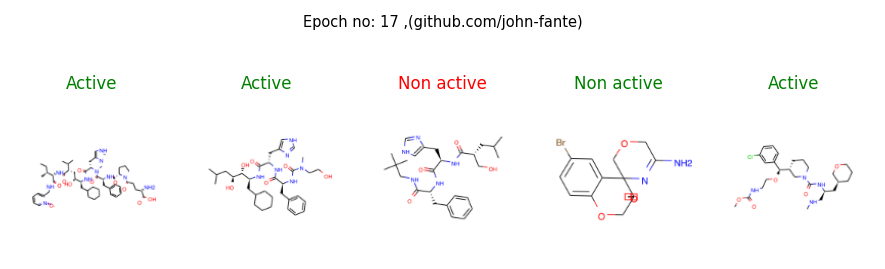

148/148 [==============================] - 23s 147ms/step - loss: 0.6263 - auc: 0.6998 - precision: 0.6342 - recall: 0.9718 - mae: 0.4375 - mse: 0.2183 - val_loss: 0.6323 - val_auc: 0.7427 - val_precision: 0.6192 - val_recall: 0.9775 - val_mae: 0.4342 - val_mse: 0.2222
Epoch 18/50
148/148 [==============================] - ETA: 0s - loss: 0.6166 - auc: 0.7066 - precision: 0.6409 - recall: 0.9577 - mae: 0.4302 - mse: 0.2142

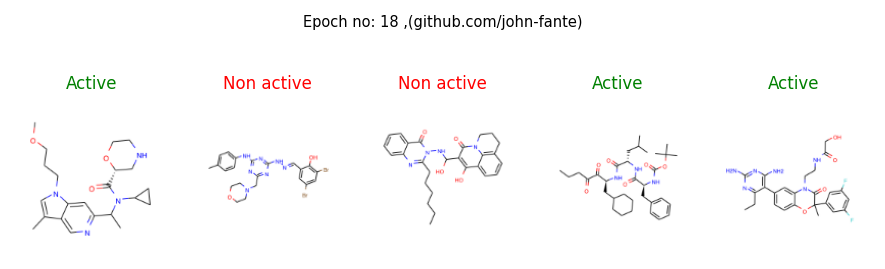

148/148 [==============================] - 23s 148ms/step - loss: 0.6166 - auc: 0.7066 - precision: 0.6409 - recall: 0.9577 - mae: 0.4302 - mse: 0.2142 - val_loss: 0.6177 - val_auc: 0.7544 - val_precision: 0.6232 - val_recall: 0.9663 - val_mae: 0.4216 - val_mse: 0.2161
Epoch 19/50
148/148 [==============================] - ETA: 0s - loss: 0.6099 - auc: 0.7043 - precision: 0.6559 - recall: 0.9183 - mae: 0.4258 - mse: 0.2111

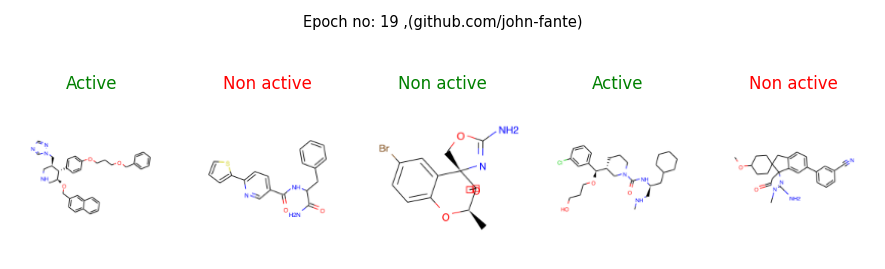

148/148 [==============================] - 23s 150ms/step - loss: 0.6099 - auc: 0.7043 - precision: 0.6559 - recall: 0.9183 - mae: 0.4258 - mse: 0.2111 - val_loss: 0.6151 - val_auc: 0.7654 - val_precision: 0.6228 - val_recall: 0.9831 - val_mae: 0.3981 - val_mse: 0.2149
Epoch 20/50
148/148 [==============================] - ETA: 0s - loss: 0.5633 - auc: 0.7645 - precision: 0.7225 - recall: 0.8986 - mae: 0.3891 - mse: 0.1892

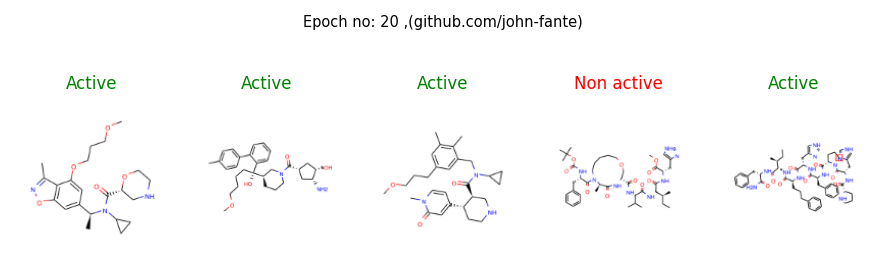

148/148 [==============================] - 23s 149ms/step - loss: 0.5633 - auc: 0.7645 - precision: 0.7225 - recall: 0.8986 - mae: 0.3891 - mse: 0.1892 - val_loss: 0.5298 - val_auc: 0.8077 - val_precision: 0.7257 - val_recall: 0.9213 - val_mae: 0.3764 - val_mse: 0.1756
Epoch 21/50
148/148 [==============================] - ETA: 0s - loss: 0.5652 - auc: 0.7580 - precision: 0.7279 - recall: 0.8592 - mae: 0.3848 - mse: 0.1904

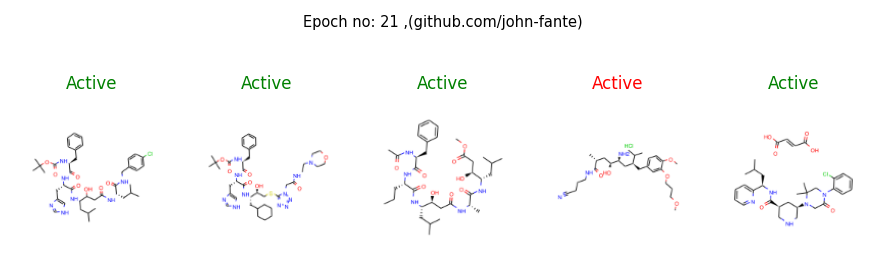

148/148 [==============================] - 24s 152ms/step - loss: 0.5652 - auc: 0.7580 - precision: 0.7279 - recall: 0.8592 - mae: 0.3848 - mse: 0.1904 - val_loss: 0.5298 - val_auc: 0.8057 - val_precision: 0.7210 - val_recall: 0.9438 - val_mae: 0.3685 - val_mse: 0.1757
Epoch 22/50
148/148 [==============================] - ETA: 0s - loss: 0.5376 - auc: 0.7867 - precision: 0.7491 - recall: 0.8620 - mae: 0.3595 - mse: 0.1782

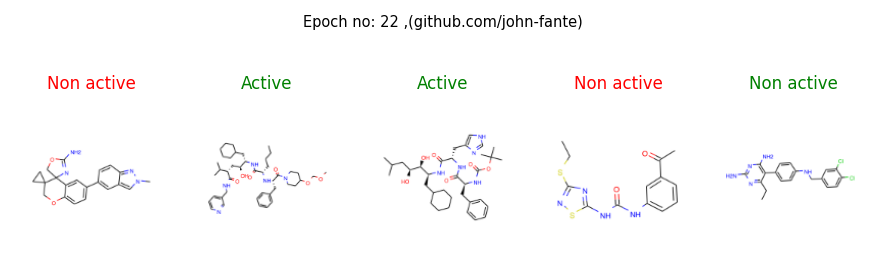

148/148 [==============================] - 24s 156ms/step - loss: 0.5376 - auc: 0.7867 - precision: 0.7491 - recall: 0.8620 - mae: 0.3595 - mse: 0.1782 - val_loss: 0.6071 - val_auc: 0.8056 - val_precision: 0.6556 - val_recall: 0.9944 - val_mae: 0.3646 - val_mse: 0.2088
Epoch 23/50
148/148 [==============================] - ETA: 0s - loss: 0.5281 - auc: 0.7899 - precision: 0.7549 - recall: 0.8634 - mae: 0.3536 - mse: 0.1750

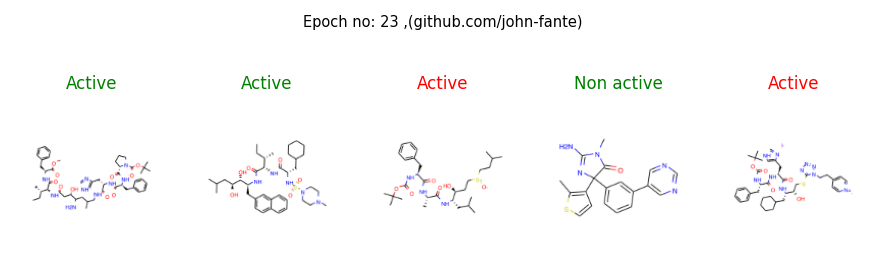

148/148 [==============================] - 25s 158ms/step - loss: 0.5281 - auc: 0.7899 - precision: 0.7549 - recall: 0.8634 - mae: 0.3536 - mse: 0.1750 - val_loss: 0.5475 - val_auc: 0.8401 - val_precision: 0.8333 - val_recall: 0.6180 - val_mae: 0.3800 - val_mse: 0.1859
Epoch 24/50
148/148 [==============================] - ETA: 0s - loss: 0.4984 - auc: 0.8153 - precision: 0.7802 - recall: 0.8901 - mae: 0.3311 - mse: 0.1613

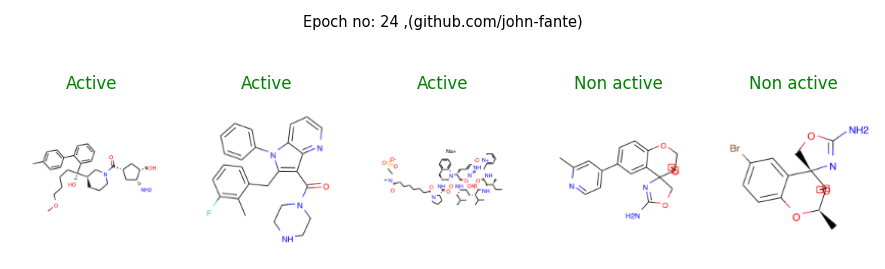

148/148 [==============================] - 24s 154ms/step - loss: 0.4984 - auc: 0.8153 - precision: 0.7802 - recall: 0.8901 - mae: 0.3311 - mse: 0.1613 - val_loss: 0.4640 - val_auc: 0.8435 - val_precision: 0.8242 - val_recall: 0.8427 - val_mae: 0.3250 - val_mse: 0.1483
Epoch 25/50
148/148 [==============================] - ETA: 0s - loss: 0.5034 - auc: 0.8056 - precision: 0.7732 - recall: 0.8789 - mae: 0.3313 - mse: 0.1645

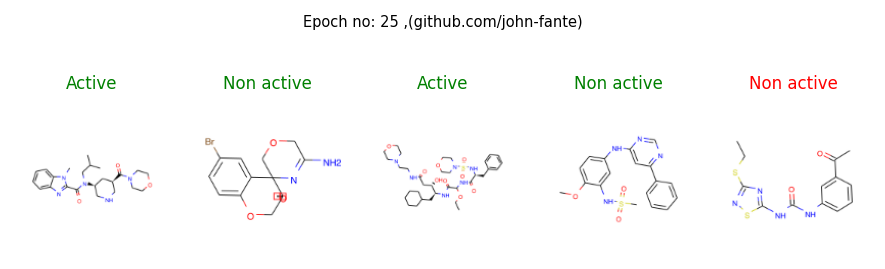

148/148 [==============================] - 25s 159ms/step - loss: 0.5034 - auc: 0.8056 - precision: 0.7732 - recall: 0.8789 - mae: 0.3313 - mse: 0.1645 - val_loss: 0.4729 - val_auc: 0.8431 - val_precision: 0.7589 - val_recall: 0.9551 - val_mae: 0.3288 - val_mse: 0.1512
Epoch 26/50
148/148 [==============================] - ETA: 0s - loss: 0.4713 - auc: 0.8371 - precision: 0.7934 - recall: 0.8761 - mae: 0.3063 - mse: 0.1513

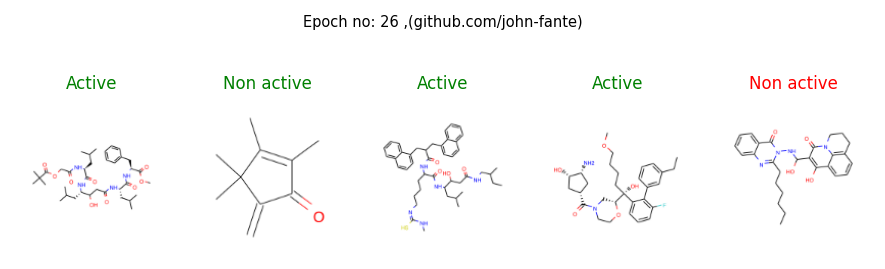

148/148 [==============================] - 25s 160ms/step - loss: 0.4713 - auc: 0.8371 - precision: 0.7934 - recall: 0.8761 - mae: 0.3063 - mse: 0.1513 - val_loss: 0.4413 - val_auc: 0.8568 - val_precision: 0.7818 - val_recall: 0.9663 - val_mae: 0.2979 - val_mse: 0.1381
Epoch 27/50
148/148 [==============================] - ETA: 0s - loss: 0.4612 - auc: 0.8489 - precision: 0.7938 - recall: 0.8676 - mae: 0.2986 - mse: 0.1484

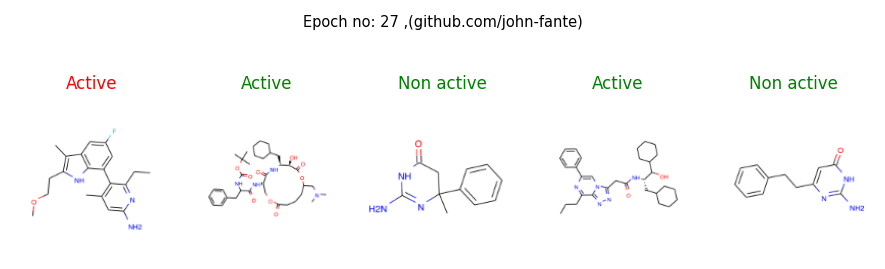

148/148 [==============================] - 24s 155ms/step - loss: 0.4612 - auc: 0.8489 - precision: 0.7938 - recall: 0.8676 - mae: 0.2986 - mse: 0.1484 - val_loss: 0.4617 - val_auc: 0.8565 - val_precision: 0.7611 - val_recall: 0.9663 - val_mae: 0.2887 - val_mse: 0.1466
Epoch 28/50
148/148 [==============================] - ETA: 0s - loss: 0.4457 - auc: 0.8532 - precision: 0.8111 - recall: 0.8887 - mae: 0.2886 - mse: 0.1403

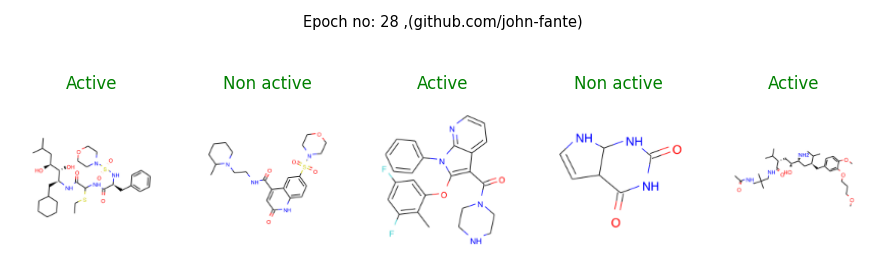

148/148 [==============================] - 24s 156ms/step - loss: 0.4457 - auc: 0.8532 - precision: 0.8111 - recall: 0.8887 - mae: 0.2886 - mse: 0.1403 - val_loss: 0.4301 - val_auc: 0.8634 - val_precision: 0.8514 - val_recall: 0.8371 - val_mae: 0.2847 - val_mse: 0.1367
Epoch 29/50
148/148 [==============================] - ETA: 0s - loss: 0.4284 - auc: 0.8620 - precision: 0.8151 - recall: 0.8944 - mae: 0.2763 - mse: 0.1343

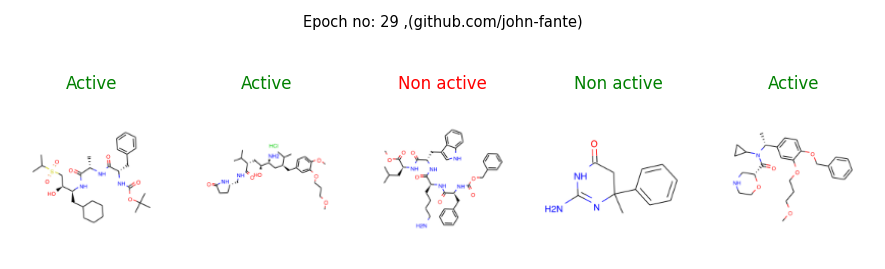

148/148 [==============================] - 25s 160ms/step - loss: 0.4284 - auc: 0.8620 - precision: 0.8151 - recall: 0.8944 - mae: 0.2763 - mse: 0.1343 - val_loss: 0.4177 - val_auc: 0.8615 - val_precision: 0.8141 - val_recall: 0.9101 - val_mae: 0.2688 - val_mse: 0.1314
Epoch 30/50
148/148 [==============================] - ETA: 0s - loss: 0.4297 - auc: 0.8622 - precision: 0.8219 - recall: 0.8972 - mae: 0.2717 - mse: 0.1335

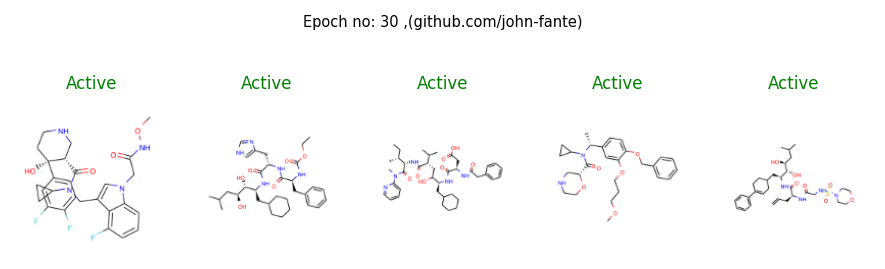

148/148 [==============================] - 23s 148ms/step - loss: 0.4297 - auc: 0.8622 - precision: 0.8219 - recall: 0.8972 - mae: 0.2717 - mse: 0.1335 - val_loss: 0.4205 - val_auc: 0.8650 - val_precision: 0.7972 - val_recall: 0.9494 - val_mae: 0.2780 - val_mse: 0.1318
Epoch 31/50
148/148 [==============================] - ETA: 0s - loss: 0.4110 - auc: 0.8757 - precision: 0.8167 - recall: 0.8972 - mae: 0.2629 - mse: 0.1287

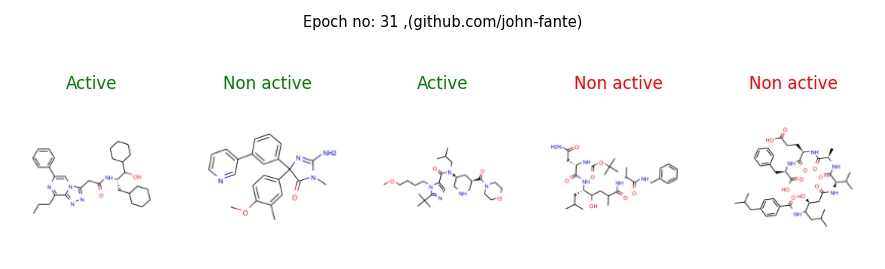

148/148 [==============================] - 24s 157ms/step - loss: 0.4110 - auc: 0.8757 - precision: 0.8167 - recall: 0.8972 - mae: 0.2629 - mse: 0.1287 - val_loss: 0.4080 - val_auc: 0.8716 - val_precision: 0.8057 - val_recall: 0.9551 - val_mae: 0.2572 - val_mse: 0.1275
Epoch 32/50
148/148 [==============================] - ETA: 0s - loss: 0.4159 - auc: 0.8742 - precision: 0.8237 - recall: 0.9014 - mae: 0.2596 - mse: 0.1297

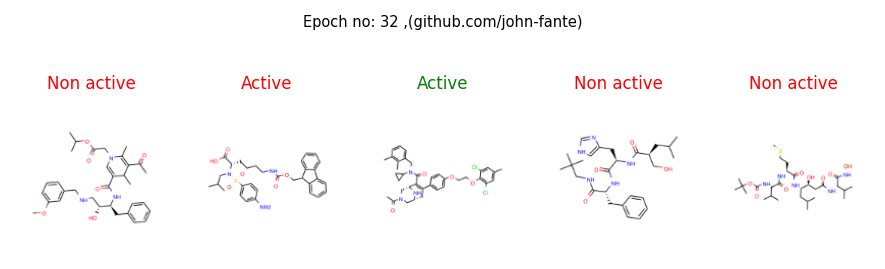

148/148 [==============================] - 24s 155ms/step - loss: 0.4159 - auc: 0.8742 - precision: 0.8237 - recall: 0.9014 - mae: 0.2596 - mse: 0.1297 - val_loss: 0.4099 - val_auc: 0.8754 - val_precision: 0.8387 - val_recall: 0.8764 - val_mae: 0.2728 - val_mse: 0.1283
Epoch 33/50
148/148 [==============================] - ETA: 0s - loss: 0.4042 - auc: 0.8792 - precision: 0.8451 - recall: 0.9141 - mae: 0.2545 - mse: 0.1249

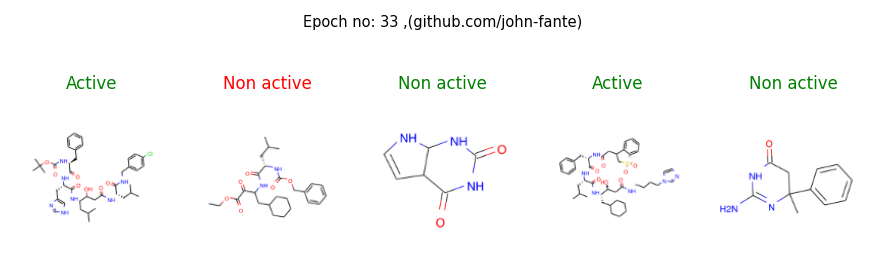

148/148 [==============================] - 24s 156ms/step - loss: 0.4042 - auc: 0.8792 - precision: 0.8451 - recall: 0.9141 - mae: 0.2545 - mse: 0.1249 - val_loss: 0.4348 - val_auc: 0.8668 - val_precision: 0.7679 - val_recall: 0.9663 - val_mae: 0.2691 - val_mse: 0.1377
Epoch 34/50
148/148 [==============================] - ETA: 0s - loss: 0.4043 - auc: 0.8823 - precision: 0.8344 - recall: 0.9014 - mae: 0.2547 - mse: 0.1256

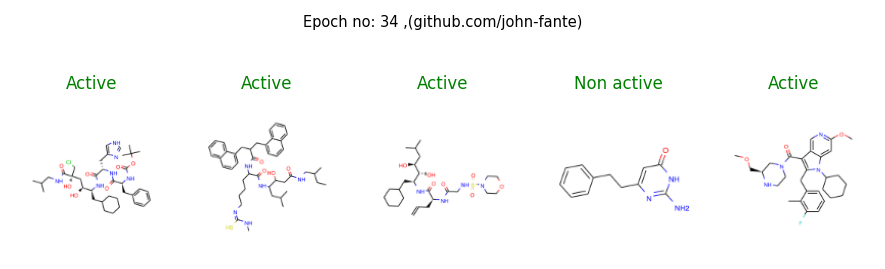

148/148 [==============================] - 25s 160ms/step - loss: 0.4043 - auc: 0.8823 - precision: 0.8344 - recall: 0.9014 - mae: 0.2547 - mse: 0.1256 - val_loss: 0.4032 - val_auc: 0.8779 - val_precision: 0.8274 - val_recall: 0.9157 - val_mae: 0.2629 - val_mse: 0.1275
Epoch 35/50
148/148 [==============================] - ETA: 0s - loss: 0.3880 - auc: 0.8865 - precision: 0.8405 - recall: 0.9127 - mae: 0.2448 - mse: 0.1192

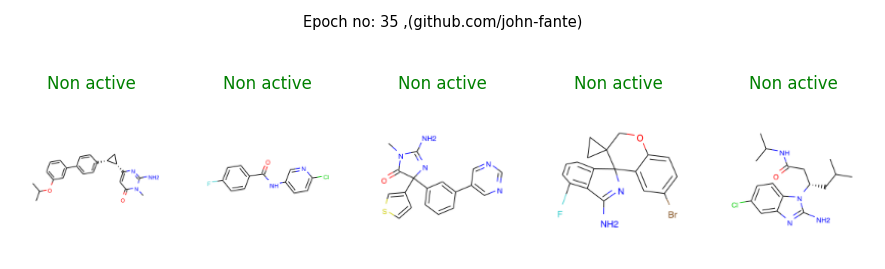

148/148 [==============================] - 25s 162ms/step - loss: 0.3880 - auc: 0.8865 - precision: 0.8405 - recall: 0.9127 - mae: 0.2448 - mse: 0.1192 - val_loss: 0.4220 - val_auc: 0.8806 - val_precision: 0.8521 - val_recall: 0.8090 - val_mae: 0.2688 - val_mse: 0.1347
Epoch 36/50
148/148 [==============================] - ETA: 0s - loss: 0.3759 - auc: 0.8916 - precision: 0.8479 - recall: 0.9028 - mae: 0.2373 - mse: 0.1150

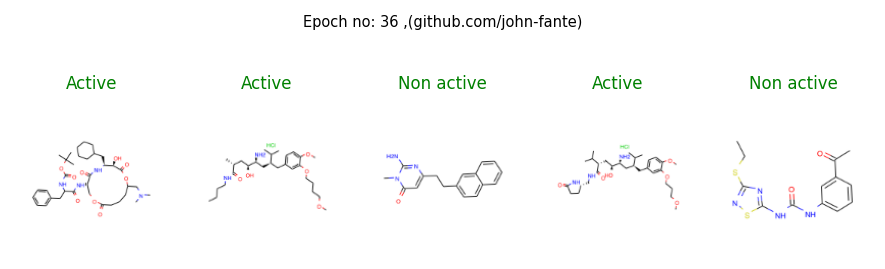

148/148 [==============================] - 24s 155ms/step - loss: 0.3759 - auc: 0.8916 - precision: 0.8479 - recall: 0.9028 - mae: 0.2373 - mse: 0.1150 - val_loss: 0.4281 - val_auc: 0.8769 - val_precision: 0.7748 - val_recall: 0.9663 - val_mae: 0.2542 - val_mse: 0.1355
Epoch 37/50
148/148 [==============================] - ETA: 0s - loss: 0.3738 - auc: 0.8972 - precision: 0.8443 - recall: 0.9239 - mae: 0.2332 - mse: 0.1147

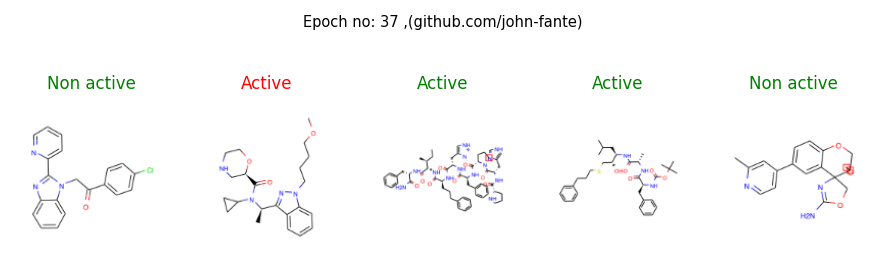

148/148 [==============================] - 24s 152ms/step - loss: 0.3738 - auc: 0.8972 - precision: 0.8443 - recall: 0.9239 - mae: 0.2332 - mse: 0.1147 - val_loss: 0.4589 - val_auc: 0.8795 - val_precision: 0.8766 - val_recall: 0.7584 - val_mae: 0.2670 - val_mse: 0.1484
Epoch 38/50
148/148 [==============================] - ETA: 0s - loss: 0.3588 - auc: 0.9042 - precision: 0.8527 - recall: 0.9211 - mae: 0.2238 - mse: 0.1096

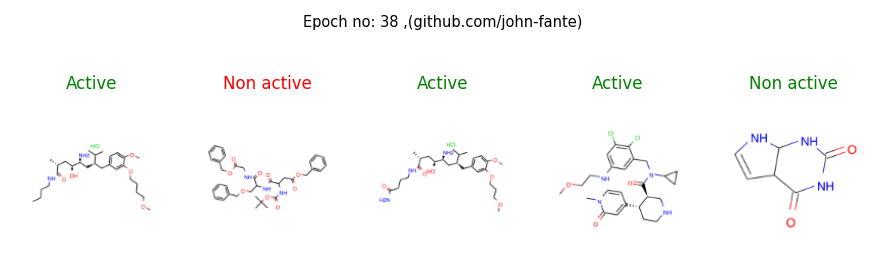

148/148 [==============================] - 23s 147ms/step - loss: 0.3588 - auc: 0.9042 - precision: 0.8527 - recall: 0.9211 - mae: 0.2238 - mse: 0.1096 - val_loss: 0.3922 - val_auc: 0.8859 - val_precision: 0.8429 - val_recall: 0.9045 - val_mae: 0.2353 - val_mse: 0.1224
Epoch 39/50
148/148 [==============================] - ETA: 0s - loss: 0.3592 - auc: 0.9069 - precision: 0.8512 - recall: 0.9183 - mae: 0.2190 - mse: 0.1097

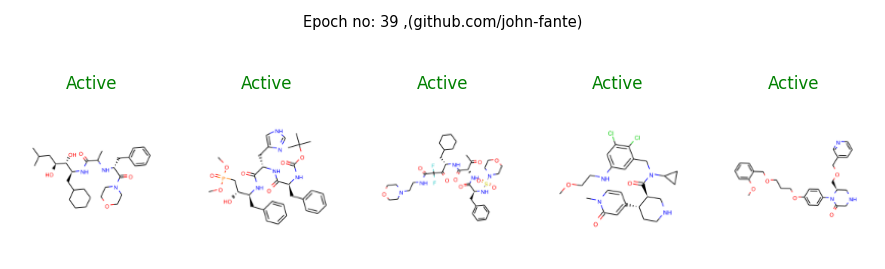

148/148 [==============================] - 24s 153ms/step - loss: 0.3592 - auc: 0.9069 - precision: 0.8512 - recall: 0.9183 - mae: 0.2190 - mse: 0.1097 - val_loss: 0.3866 - val_auc: 0.8841 - val_precision: 0.8259 - val_recall: 0.9326 - val_mae: 0.2391 - val_mse: 0.1206
Epoch 40/50
148/148 [==============================] - ETA: 0s - loss: 0.3541 - auc: 0.9069 - precision: 0.8512 - recall: 0.9183 - mae: 0.2223 - mse: 0.1083

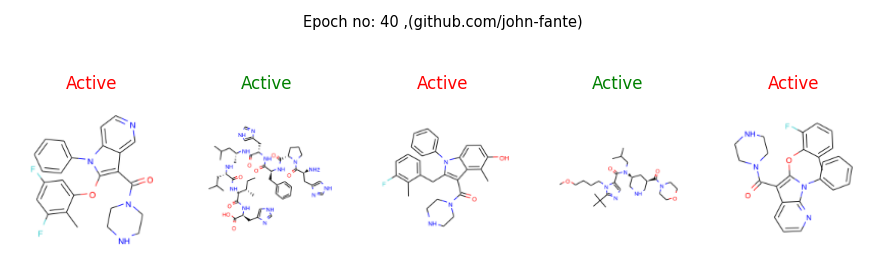

148/148 [==============================] - 25s 156ms/step - loss: 0.3541 - auc: 0.9069 - precision: 0.8512 - recall: 0.9183 - mae: 0.2223 - mse: 0.1083 - val_loss: 0.4354 - val_auc: 0.8847 - val_precision: 0.8773 - val_recall: 0.8034 - val_mae: 0.2540 - val_mse: 0.1378
Epoch 41/50
148/148 [==============================] - ETA: 0s - loss: 0.3323 - auc: 0.9147 - precision: 0.8638 - recall: 0.9380 - mae: 0.2023 - mse: 0.0995

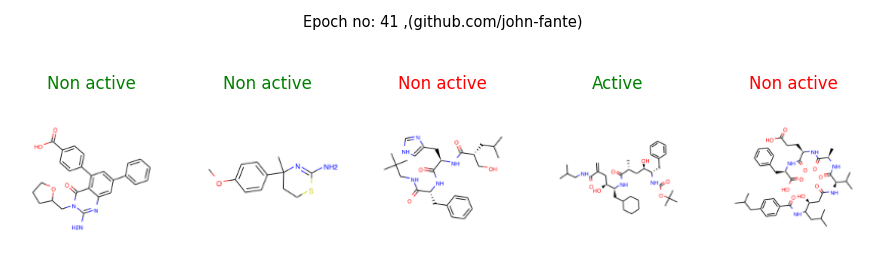

148/148 [==============================] - 24s 154ms/step - loss: 0.3323 - auc: 0.9147 - precision: 0.8638 - recall: 0.9380 - mae: 0.2023 - mse: 0.0995 - val_loss: 0.4132 - val_auc: 0.8893 - val_precision: 0.8539 - val_recall: 0.8539 - val_mae: 0.2479 - val_mse: 0.1285
Epoch 42/50
148/148 [==============================] - ETA: 0s - loss: 0.3315 - auc: 0.9217 - precision: 0.8630 - recall: 0.9225 - mae: 0.2065 - mse: 0.1007

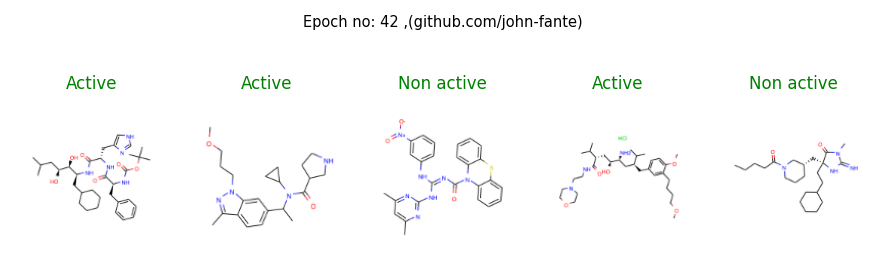

148/148 [==============================] - 26s 165ms/step - loss: 0.3315 - auc: 0.9217 - precision: 0.8630 - recall: 0.9225 - mae: 0.2065 - mse: 0.1007 - val_loss: 0.3931 - val_auc: 0.8956 - val_precision: 0.8516 - val_recall: 0.8708 - val_mae: 0.2381 - val_mse: 0.1237
Epoch 43/50
148/148 [==============================] - ETA: 0s - loss: 0.3284 - auc: 0.9199 - precision: 0.8637 - recall: 0.9282 - mae: 0.1991 - mse: 0.0992

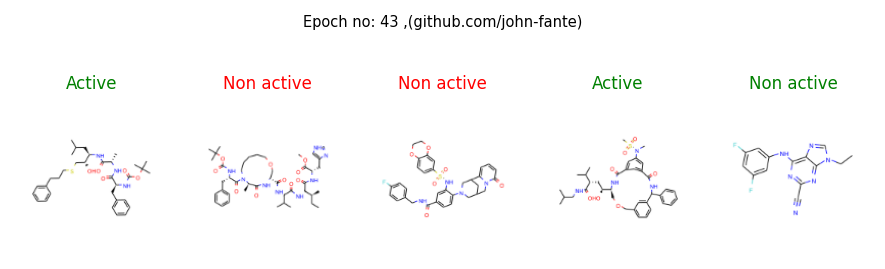

148/148 [==============================] - 24s 157ms/step - loss: 0.3284 - auc: 0.9199 - precision: 0.8637 - recall: 0.9282 - mae: 0.1991 - mse: 0.0992 - val_loss: 0.4152 - val_auc: 0.8856 - val_precision: 0.7934 - val_recall: 0.9494 - val_mae: 0.2360 - val_mse: 0.1322
Epoch 44/50
148/148 [==============================] - ETA: 0s - loss: 0.3216 - auc: 0.9214 - precision: 0.8649 - recall: 0.9380 - mae: 0.1971 - mse: 0.0969

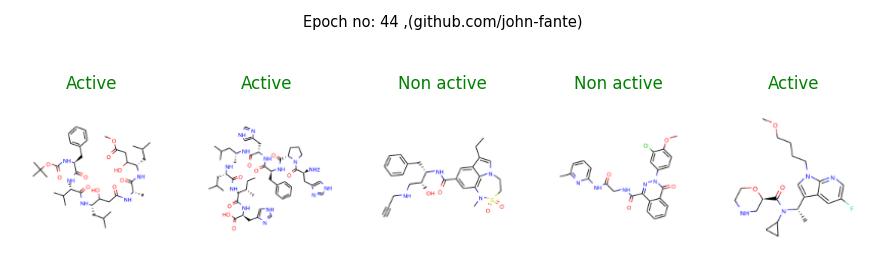

148/148 [==============================] - 25s 162ms/step - loss: 0.3216 - auc: 0.9214 - precision: 0.8649 - recall: 0.9380 - mae: 0.1971 - mse: 0.0969 - val_loss: 0.4664 - val_auc: 0.8865 - val_precision: 0.7543 - val_recall: 0.9831 - val_mae: 0.2495 - val_mse: 0.1505
Epoch 45/50
148/148 [==============================] - ETA: 0s - loss: 0.2985 - auc: 0.9306 - precision: 0.8760 - recall: 0.9451 - mae: 0.1857 - mse: 0.0882

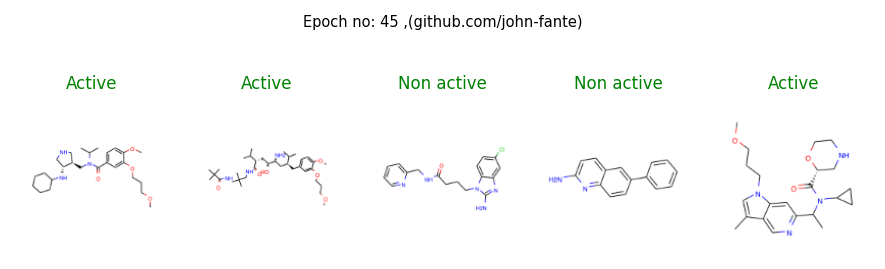

148/148 [==============================] - 25s 164ms/step - loss: 0.2985 - auc: 0.9306 - precision: 0.8760 - recall: 0.9451 - mae: 0.1857 - mse: 0.0882 - val_loss: 0.4122 - val_auc: 0.8941 - val_precision: 0.7907 - val_recall: 0.9551 - val_mae: 0.2128 - val_mse: 0.1289
Epoch 46/50
148/148 [==============================] - ETA: 0s - loss: 0.2708 - auc: 0.9448 - precision: 0.8906 - recall: 0.9521 - mae: 0.1655 - mse: 0.0784

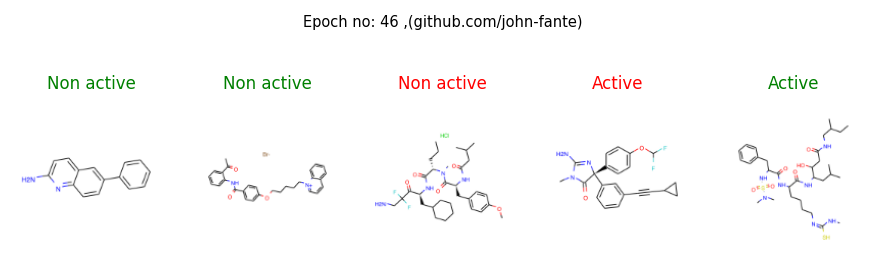

148/148 [==============================] - 26s 165ms/step - loss: 0.2708 - auc: 0.9448 - precision: 0.8906 - recall: 0.9521 - mae: 0.1655 - mse: 0.0784 - val_loss: 0.4118 - val_auc: 0.8952 - val_precision: 0.7934 - val_recall: 0.9494 - val_mae: 0.2125 - val_mse: 0.1292
Epoch 47/50
148/148 [==============================] - ETA: 0s - loss: 0.2908 - auc: 0.9351 - precision: 0.8805 - recall: 0.9338 - mae: 0.1767 - mse: 0.0861

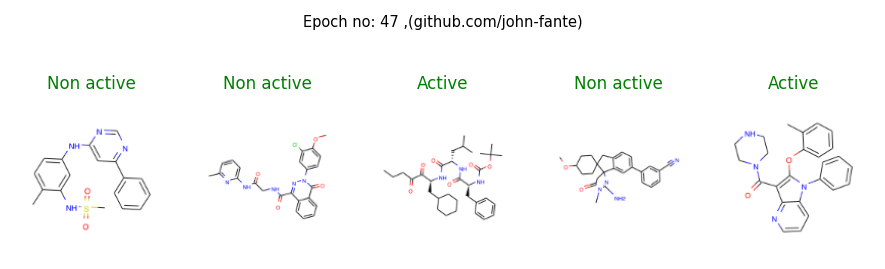

148/148 [==============================] - 25s 163ms/step - loss: 0.2908 - auc: 0.9351 - precision: 0.8805 - recall: 0.9338 - mae: 0.1767 - mse: 0.0861 - val_loss: 0.4062 - val_auc: 0.8984 - val_precision: 0.8048 - val_recall: 0.9494 - val_mae: 0.2097 - val_mse: 0.1258
Epoch 48/50
148/148 [==============================] - ETA: 0s - loss: 0.2666 - auc: 0.9444 - precision: 0.8912 - recall: 0.9465 - mae: 0.1642 - mse: 0.0777

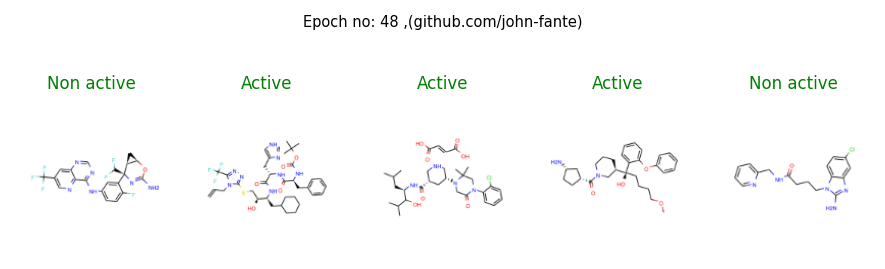

148/148 [==============================] - 25s 161ms/step - loss: 0.2666 - auc: 0.9444 - precision: 0.8912 - recall: 0.9465 - mae: 0.1642 - mse: 0.0777 - val_loss: 0.3836 - val_auc: 0.9031 - val_precision: 0.8177 - val_recall: 0.9326 - val_mae: 0.2080 - val_mse: 0.1200
Epoch 49/50
148/148 [==============================] - ETA: 0s - loss: 0.2873 - auc: 0.9366 - precision: 0.8781 - recall: 0.9437 - mae: 0.1686 - mse: 0.0853

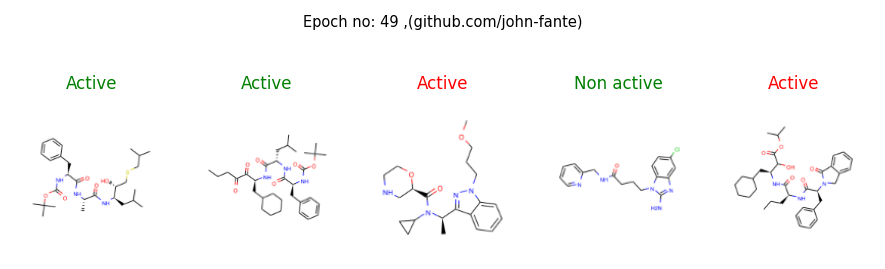

148/148 [==============================] - 25s 160ms/step - loss: 0.2873 - auc: 0.9366 - precision: 0.8781 - recall: 0.9437 - mae: 0.1686 - mse: 0.0853 - val_loss: 0.4572 - val_auc: 0.8946 - val_precision: 0.8696 - val_recall: 0.7865 - val_mae: 0.2688 - val_mse: 0.1420
Epoch 50/50
148/148 [==============================] - ETA: 0s - loss: 0.2578 - auc: 0.9510 - precision: 0.8861 - recall: 0.9423 - mae: 0.1595 - mse: 0.0765

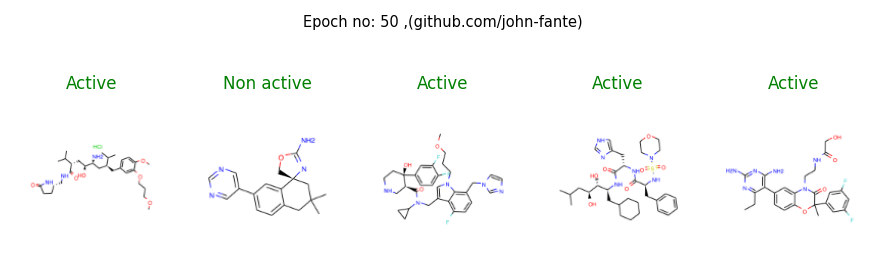

148/148 [==============================] - 26s 161ms/step - loss: 0.2578 - auc: 0.9510 - precision: 0.8861 - recall: 0.9423 - mae: 0.1595 - mse: 0.0765 - val_loss: 0.3790 - val_auc: 0.9025 - val_precision: 0.8438 - val_recall: 0.9101 - val_mae: 0.2284 - val_mse: 0.1164


In [12]:
hist = model.fit(train_dataset,
                 epochs = 50 ,
                 batch_size = BATCH_SIZE,
                 validation_data= validation_dataset,
                 callbacks = my_callbacks )

#Model 1: Results

Text(0.5, 1.0, 'Recall')

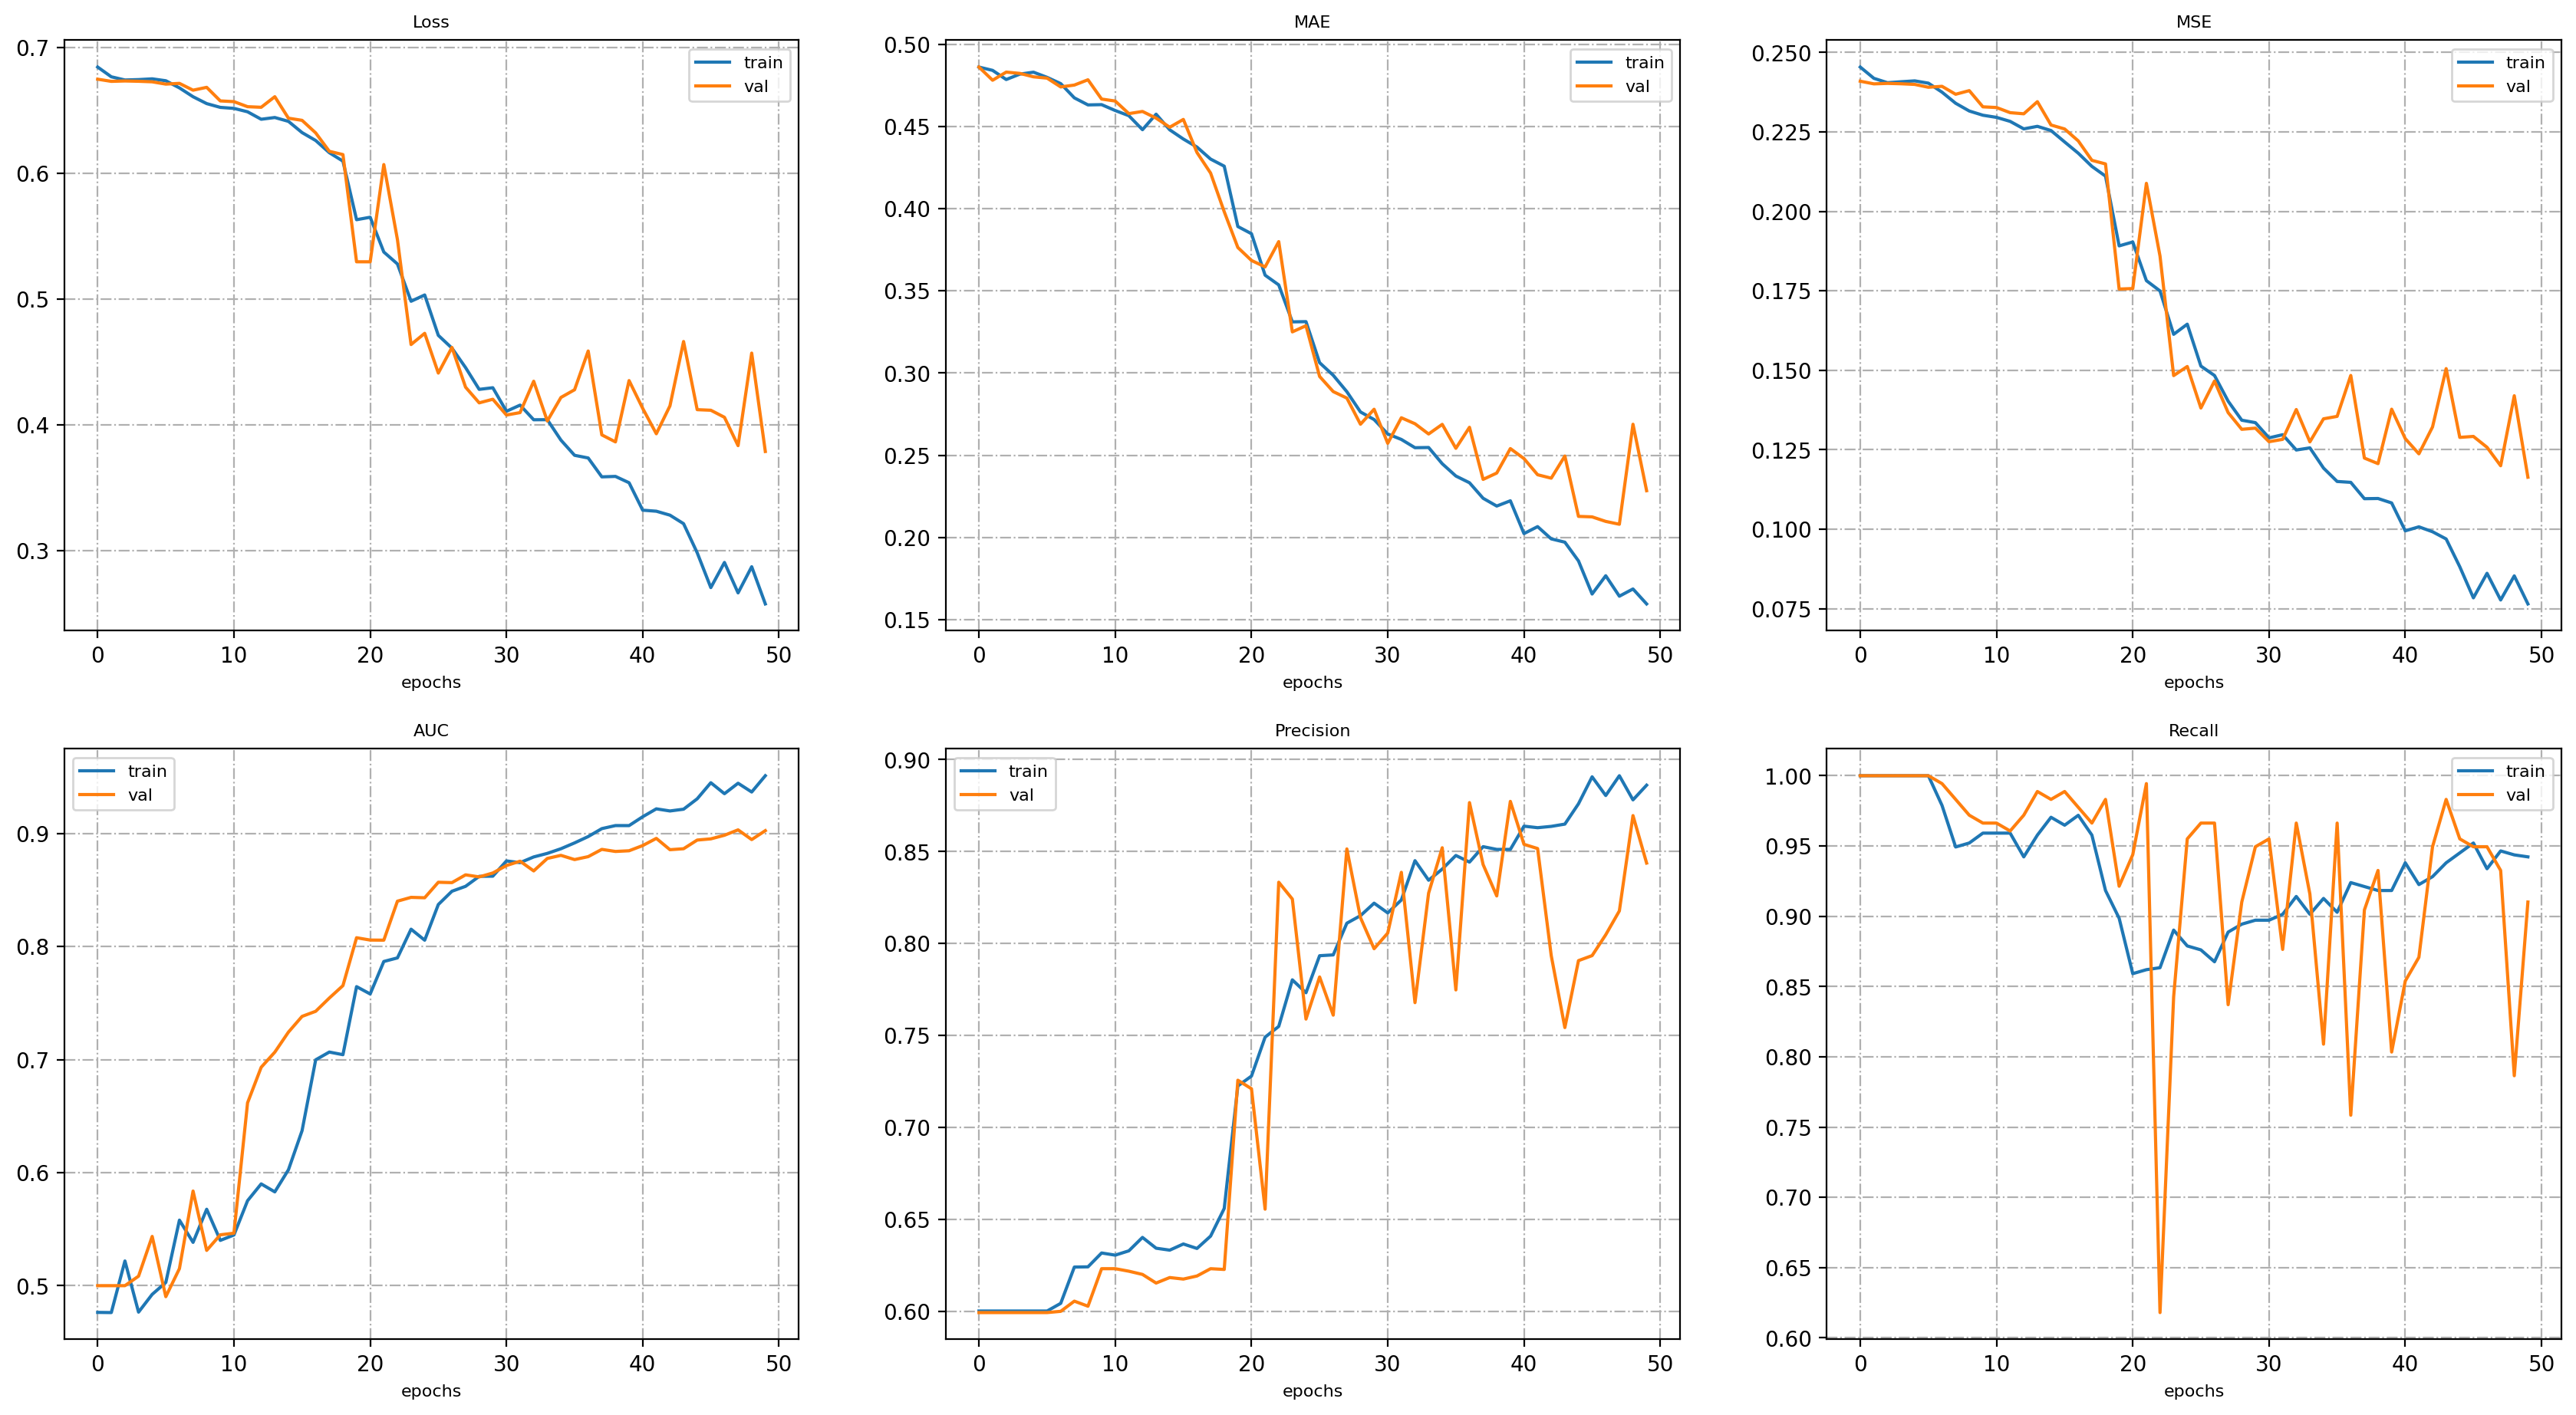

In [13]:
fig, axs = plt.subplots(2,3 , figsize = ( 21, 11 ), dpi = 200)

axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].plot(hist.history['loss'] )
axs[0][0].plot(hist.history['val_loss'] )
axs[0][0].set_xlabel('epochs', fontsize = 8)
axs[0][0].legend(['train', 'val'], fontsize = 8)
axs[0][0].set_title('Loss', fontsize = 8)


axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].plot(hist.history['mae'] )
axs[0][1].plot(hist.history['val_mae'] )
axs[0][1].set_xlabel('epochs', fontsize = 8)
axs[0][1].legend(['train', 'val'], fontsize = 8)
axs[0][1].set_title('MAE', fontsize = 8)

axs[0][2].grid(linestyle = 'dashdot')
axs[0][2].plot(hist.history['mse'] )
axs[0][2].plot(hist.history['val_mse'] )
axs[0][2].set_xlabel('epochs', fontsize = 8)
axs[0][2].legend(['train', 'val'], fontsize = 8)
axs[0][2].set_title('MSE', fontsize = 8)

axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].plot(hist.history['auc'])
axs[1][0].plot(hist.history['val_auc'] )
axs[1][0].set_xlabel('epochs', fontsize = 8)
axs[1][0].legend(['train', 'val'], fontsize = 8)
axs[1][0].set_title('AUC', fontsize = 8)

axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].plot(hist.history['precision'])
axs[1][1].plot(hist.history['val_precision'] )
axs[1][1].set_xlabel('epochs', fontsize = 8)
axs[1][1].legend(['train', 'val'], fontsize = 8)
axs[1][1].set_title('Precision', fontsize = 8)

axs[1][2].grid(linestyle = 'dashdot')
axs[1][2].plot(hist.history['recall'])
axs[1][2].plot(hist.history['val_recall'] )
axs[1][2].set_xlabel('epochs', fontsize = 8)
axs[1][2].legend(['train', 'val'], fontsize = 8)
axs[1][2].set_title('Recall', fontsize = 8)



#Model 1: Test Prediction, Evaluation

In [14]:
# Test set evaluation

test_eval = model.evaluate(test_dataset)

print('test auc : {0:.3f}'.format(test_eval[1]))
print('test precision : {0:.3f}'.format(test_eval[2]))
print('test recall : {0:.3f}'.format(test_eval[3]))

47/47 [==============================] - 2s 45ms/step - loss: 0.4115 - auc: 0.8762 - precision: 0.8112 - recall: 0.9058 - mae: 0.2435 - mse: 0.1302
test auc : 0.876
test precision : 0.811
test recall : 0.906


In [15]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred_ = np.round(pred)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

47/47 [==============================] - 2s 40ms/step


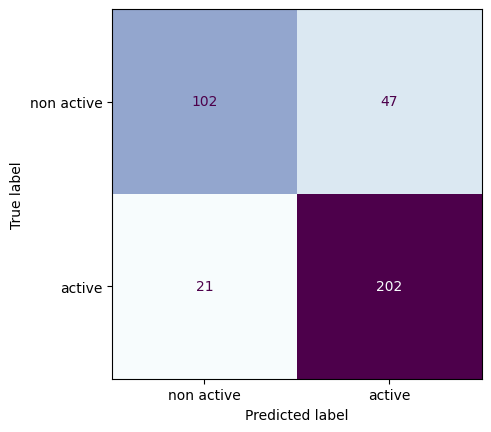

In [187]:
# Plotting the confusion matrix of the CNN Model

cm = confusion_matrix(y_test_take, pred_)
cmd = ConfusionMatrixDisplay(cm, display_labels= ['non active','active'])
cmd.plot(cmap = 'BuPu',colorbar = False )


In [54]:
rp = classification_report(y_test_take, pred_)
print(rp)

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       149
           1       0.81      0.91      0.86       223

    accuracy                           0.82       372
   macro avg       0.82      0.80      0.80       372
weighted avg       0.82      0.82      0.81       372



#Model 2: CNN Feature Extraction and CatBoostClassifier

In [210]:
inp = Input(shape = (150, 150, 3))
c = ConvBlock(32, 2, activation = 'elu', batchnormalization = True, name = 'conv1')(inp)
c = ConvBlock(64, 2, activation = 'elu', batchnormalization = True , name = 'conv2')(c)
c = ConvBlock(128, 2, activation = 'elu', batchnormalization = True, name = 'conv3' )(c)
c = ConvBlock(150, 2, activation = 'elu', batchnormalization = True, name = 'conv4' )(c)
c = GlobalAveragePooling2D()(c)


model2 = Model(inputs = inp, outputs = c)
model2.summary()

model2.compile(optimizer = tf.keras.optimizers.Adam(), loss ='binary_crossentropy')
my_callbacks2 = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.0001, patience = 5 ) ]


#Plotting the model

plt.figure(dpi = 100)
visualkeras.layered_view(model2, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True)

hist2 = model2.fit(train_dataset_without_shuffle,
                   epochs = 100,
                   batch_size = BATCH_SIZE,
                    callbacks = my_callbacks2)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (ConvBlock)           (None, 75, 75, 32)        544       
                                                                 
 conv2 (ConvBlock)           (None, 37, 37, 64)        8512      
                                                                 
 conv3 (ConvBlock)           (None, 18, 18, 128)       33408     
                                                                 
 conv4 (ConvBlock)           (None, 9, 9, 150)         77550     
                                                                 
 global_average_pooling2d_9  (None, 150)               0         
  (GlobalAveragePooling2D)                                       
                                                           

<Figure size 640x480 with 0 Axes>

In [211]:
# Feature extraction

train_feat = model2.predict(train_dataset_without_shuffle)
val_feat = model2.predict(validation_dataset)
test_feat = model2.predict(test_dataset)

47/47 [==============================] - 3s 60ms/step


#Model 2: CatBoostClassifier for Classification


In [241]:
cat_model = CatBoostClassifier(iterations = 2500)
cat_model.fit(train_feat, train_data['labels'], verbose = 500 )

Learning rate set to 0.004777
0:	learn: 0.6839207	total: 108ms	remaining: 4m 30s
500:	learn: 0.0657040	total: 14.3s	remaining: 57.2s
1000:	learn: 0.0448916	total: 28.3s	remaining: 42.3s
1500:	learn: 0.0327731	total: 42.2s	remaining: 28.1s
2000:	learn: 0.0238370	total: 57.1s	remaining: 14.2s
2499:	learn: 0.0177866	total: 1m 11s	remaining: 0us


In [242]:
cat_pred = cat_model.predict(test_feat)

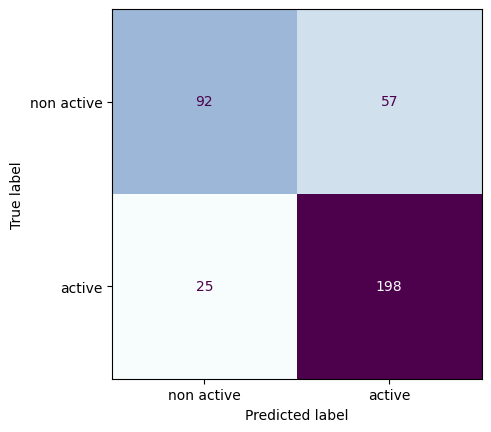

In [243]:
# Plotting the confusion matrix of the CatBoostClassifier Model

cm2 = confusion_matrix(test_data['labels'], cat_pred)
cmd2 = ConfusionMatrixDisplay(cm2, display_labels= ['non active','active'])
cmd2.plot(cmap = 'BuPu',colorbar = False )

In [244]:
rp2 = classification_report(test_data['labels'], cat_pred)
print(rp2)

              precision    recall  f1-score   support

           0       0.79      0.62      0.69       149
           1       0.78      0.89      0.83       223

    accuracy                           0.78       372
   macro avg       0.78      0.75      0.76       372
weighted avg       0.78      0.78      0.77       372



#Model 3: Ensemble Weighted Classifier

In [245]:
def weighted_classifier(pred1 , pred2, model1_weight, model2_weight):
  last_preds = []
  for i in range(len(pred1)):
    pred = pred1[i]*model1_weight + pred2[i]*model2_weight
    last_preds.append(pred[0])

  return np.round(last_preds)

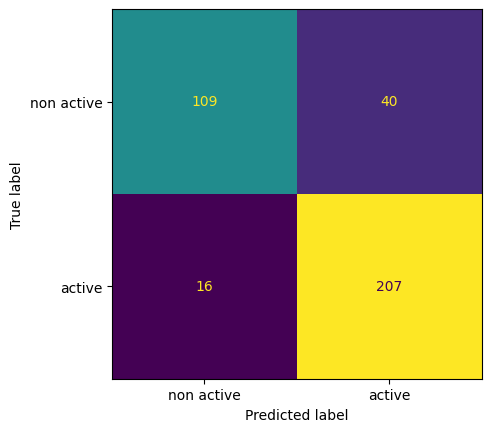

In [246]:
# Plotting the confusion matrix of the Ensemble Model
# I have used 70% of the first model's prediction and 30% of the second model's prediction

weighted_pred = weighted_classifier(pred, cat_pred, 0.7, 0.3)

cm3 = confusion_matrix(test_data['labels'], weighted_pred)
cmd2 = ConfusionMatrixDisplay(cm3, display_labels= ['non active','active'])
cmd2.plot(colorbar = False )

In [247]:
rp3 = classification_report(test_data['labels'], weighted_pred)
print(rp3)

              precision    recall  f1-score   support

           0       0.87      0.73      0.80       149
           1       0.84      0.93      0.88       223

    accuracy                           0.85       372
   macro avg       0.86      0.83      0.84       372
weighted avg       0.85      0.85      0.85       372

